This blog is inspired by [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829) and aims to understand Capsule Networks with hands-on coding. 

I use Keras with tensorflow backend. The codes here are created by modifing [Kevin Mader's ipython notebook script in Kaggle competition](https://www.kaggle.com/kmader/capsulenet-on-mnist), which, in turn are written by adapting [Xifeng Guo's script in Github](https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulenet.py).


CapsNet is cool in many ways but I was particularly impressed with the following claims that the authors made:

1. CapsNet requires less parameters to achieve lower validation error (0.25%) the state of art (0.39%). This CapsNet model "only" has 8M parameters while the baseline (current state of art) requires 35M parameters.
2. CapsNet is interpretable. 
3. CapsNet is more robust than state of art.
4. CapsNet needs less images for training.

In this blog, I examine the points 1 and 2, and would like to discuss the points 3 and 4 in [Assess the robustness of CapsNet](https://fairyonice.github.io/Assess%20the%20robustness%20of%20CapsNet.html). 

## Findings:
- I was able to use Capsule Network to return validation error of 0.42%, which is less than [my baseline](https://fairyonice.github.io/CNN%20modeling%20with%20image%20translations%20using%20MNIST%20data.html) (0.54%).
- Intepretation of the capsules is possible but it requires some efforts.


## Reference: 

- [Kaggle competition](https://www.kaggle.com/kmader/capsulenet-on-mnist)
- [Siraj Raval's YouTube video](https://www.youtube.com/watch?v=VKoLGnq15RM&t=912s)
- [Jonathan Hui's blog](https://jhui.github.io/2017/11/03/Dynamic-Routing-Between-Capsules/)
  <- This blog helped me a lot to understand the techinical details. So thank you very much Jonathan!
- [Max Pechyonkin's blog](https://medium.com/ai%C2%B3-theory-practice-business/understanding-hintons-capsule-networks-part-i-intuition-b4b559d1159b)  
- [My previous blog](https://fairyonice.github.io/CNN%20modeling%20with%20image%20translations%20using%20MNIST%20data.html)

Importing necessary modules


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
#### 2 GPU1
#### 0 GPU3
#### 4 GPU4
#### 3 GPU2
set_session(tf.Session(config=config))

Using TensorFlow backend.


python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
keras version 2.0.6
tensorflow version 1.2.1


### Core functions for DigitCaps and PrimaryCaps

In [2]:
import keras.backend as K
from keras import initializers, layers
from keras import models

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    
    This class is used to reduce the dimention of the 
    
    (Nsample, n_class, dim_vector) --> (Nsample, dim_vector)
    For training:
        only keep the activity vector (v in paper) of true class 
    for testing
        only keep the activity vector with the largest norm (length in vector)
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, ## 8 x 32
                           kernel_size=kernel_size,       ## 9x9
                           strides=strides,               ## 2   
                           padding=padding,name="PrimaryCap_conv2d")(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector],name="PrimaryCap_reshape")(output)
    return layers.Lambda(squash,name="PrimaryCap_squash")(outputs)

def NetworkInputToDigitCap(input_shape,n_class,num_routing):
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, 
                          strides=1, padding='valid', activation='relu', 
                          name='Conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, 
    #          then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, 
                             n_channels=32, kernel_size=9, 
                             strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, 
                             dim_vector=16, num_routing=num_routing, 
                             name='DigitCaps')(primarycaps)
    

    return(x, digitcaps)

## CapsNet function

In [3]:

from keras import backend as K

def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x, digitcaps = NetworkInputToDigitCap(input_shape,n_class, num_routing)
    
    # Layer 4: This is an auxiliary layer to replace each capsule with its length. 
    #          Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps) ##||v|| margin_loss
    
    # Decoder network.
    y = layers.Input(shape=(n_class,),name="true_label") 
    masked = Mask(name="activity_vec")([digitcaps, ## digitcaps.shape = (Nsample, n_class, dim_vector )
                     y])  # The true label is used to mask the output of capsule layer.
    
    x_recon = Decoder(masked)

    # two-input-two-output keras Model
    m1 = models.Model([x, y], [out_caps, x_recon])
    m2 = models.Model([x],[digitcaps]) ## YUMI added this line
    return m1, m2 



def Decoder(masked):
    ## Yumi refactored
    x_recon = layers.Dense(512, activation='relu',name="FC1")(masked)
    x_recon = layers.Dense(1024, activation='relu',name="FC2")(x_recon)
    x_recon = layers.Dense(784, activation='sigmoid',name="FC3")(x_recon)
    ## mse to ensure that the reconstructed images are close to the original image.
    x_recon = layers.Reshape(target_shape=[28, 28, 1], name='out_recon')(x_recon) 
    return(x_recon)
    
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))



## CapsNet outputs:
- model: Keras's model object for entire CapsNet 
- model_wo_decoder: Keras's model object without encoder parts

CapsNet has decoder subnetwork which reconstruct the image from the 16-dimensional activity vector.
The model without the decoder subnetwork only contains the single ouputs which are the output vectors of capsule.
I create a model without the decoder subnetwork so that I can easily access the output vectors of capsules.  

These two model objects share weights. 
I will train using "model" this will automatically update the digitcaps's weights.

## CapsNet architecture:
The summary shows CapsNet architecture.


It is always good to check the understanding of model by checking the number of parameters produced by Keras model and your own calculation!
  
**input_1** : 28 x 28 frame image 

**Conv1**   : 256, 9 x 9 convolution kernels with a stride of 1 and Relu activation

   -  Param N : 20,992 = 256 x (1 x (9 x 9) + 1), 
       - +1 for bias
   -  The 1st and 2nd dim of output is 20 = (28 - 9 + 1)/1 

**PrimaryCamspules layer** : convolusional capsule layer with 32 channels of convolutional 8D capsules (each primary capsule contains 8 convolutional units with a 9 x 9 kernel and a stride of 2).

   - Param N : 5,308,672 = (32 x 8) x (256 x (9 x 9 ) + 1) 
   - The input of Primary Camspules is 256 20 x 20 feature maps.
   - For each feature map, 9 x 9 kernel with stride 2 and no padding is applied 32 x 8 times.
   - Each input feature map is reduced to 6 x 6 feature maps (6 = floor[ (20 - 9)/2 ] + 1) and there are 32 x 8 of such feature maps. Therefore, the output dimention is 6 x 6 x (32 x 8). Each group of 8 feature maps is considered as a capsule.
This layer returns: $\boldsymbol{u}_i \in R^8, i=1,..., 6 * 6 * 32$

**DigiCaps layer** :
- Param N : 1,486,080 = 16 x 8 x (6 x 6 x 32) x 10 + 6 x 6 x 32 x 10

This is the core layer for Capsule Network.
The index $j$ represents the index for output class $j=1,...,10$ and let $c_{i,j} \in R^1,\boldsymbol{W}_{i,j} \in R^{16 x 8} $ and $\boldsymbol{v}_j \in R^{16}$.

$$
\widehat{\boldsymbol{u}}_{j|i} = \boldsymbol{W}_{i,j} \boldsymbol{u}_i\\
\boldsymbol{s}_j = \sum_{i=1}^{6 x 6 x32} c_{i,j} \widehat{\boldsymbol{u}}_{j|i}\\
\boldsymbol{v}_j = 
\frac{
||\boldsymbol{s}_j||^2
}{
1 + ||\boldsymbol{s}_j||^2
}
\frac{
\boldsymbol{s}_j
}{
 ||\boldsymbol{s}_j||
}
$$

DigiCaps layer contains 2 types of unknown weights: $c_{i,j}$ and $\boldsymbol{W}_{i,j}$. 

- As $c_{i,j} \in R^1$, we have 1 x (6 x 6 x 32) x 10 parameters.
- As $\boldsymbol{W}_{i,j} \in R^{16 x 8} $, we have 1,474,560 = (16 x 8 x (6 x 6 x 32) x 10) parameters for the affine transfomation matrix

The output is 10 x 16.





In [4]:
def myprint():
    print("~~~"*10)

## define model
n_class = 10
model, model_wo_decoder = CapsNet(input_shape=[28, 28, 1],
                           n_class=n_class,
                           num_routing=3)

myprint()
print("Capsule Net (all)")
myprint()
model.summary()


myprint()
print("Capsule Net (without the decoder)")
myprint()
model_wo_decoder.summary()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Capsule Net (all)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
Conv1 (Conv2D)                   (None, 20, 20, 256)   20992       input_1[0][0]                    
____________________________________________________________________________________________________
PrimaryCap_conv2d (Conv2D)       (None, 6, 6, 256)     5308672     Conv1[0][0]                      
____________________________________________________________________________________________________
PrimaryCap_reshape (Reshape)     (None, 1152, 8)       0           PrimaryCap_conv2d[0][0]          
___________

## Load data

Keras has nice API to extract MNIST data. Using keras.datasets, we can readily load data.
```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
```
However, I have a connection issue in accessing MNIST data via this API.
So instead, I use [python-mnist](https://github.com/sorki/python-mnist) for loading data.

Split between training and testing. 
Following paper, 60K and 10K images are used for training and testing respectively.
I reshape the data. 

In [5]:
from mnist import MNIST
import numpy as np
from keras.utils import to_categorical

mndata = MNIST('./MNIST_data/')

images, labels = mndata.load_training()
x_train, y_train = np.array(images),np.array(labels)

images, labels = mndata.load_testing()
x_test, y_test = np.array(images),np.array(labels)


x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = to_categorical(y_train.astype('float32'))
y_test = to_categorical(y_test.astype('float32'))
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))


### Train CapsNet
As in paper, training is performed on 28 x 28 MNIST images that have been shifted by up to 2 pixels in each direction with zero padding.
This is done using Keras's ImageDataGenerator API. See [my prebious blog](https://fairyonice.github.io/CNN%20modeling%20with%20image%20translations%20using%20MNIST%20data.html) that discusses the useage of this API.


In [6]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
from datetime import datetime 
from numpy.random import seed
from tensorflow import set_random_seed

def train(model, data, epochs, epoch_size_frac=1.0):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    start = datetime.today()
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'out_caps': 'accuracy'})
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint(
        'weights-{epoch:02d}.h5',
        save_best_only=True, 
        save_weights_only=True, 
        verbose=False)
    lr_decay = callbacks.LearningRateScheduler(
        schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # compile the model
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'out_caps': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint])
    """

    # -----------------------------------Begin: Training with data augmentation -----------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    hist = model.fit_generator(
                        generator=train_generator(x_train, y_train, 64, 0.1),
                        steps_per_epoch=int(epoch_size_frac*y_train.shape[0] / 64),
                        epochs=epochs,
                        verbose=2,
                        validation_data=[[x_test, y_test], 
                                         [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay])
    # -----------------------------------End: Training with data augmentation -----------------------------------#

    end = datetime.today()
    
    print("_"*10)
    print("Time Took: {}".format(end - start))
    return hist

The paper did not say exact number of epochs. 
Here, I try 100 epochs.

In [7]:
seed(1)
set_random_seed(1)


hist = train(model=model, 
             epochs= 100,#50,
             data=((x_train, y_train), (x_test, y_test)), 
             epoch_size_frac = 1) 

Epoch 1/100
382s - loss: 0.0840 - out_caps_loss: 0.0839 - out_recon_loss: 0.0818 - out_caps_acc: 0.9204 - val_loss: 0.0248 - val_out_caps_loss: 0.0248 - val_out_recon_loss: 0.0585 - val_out_caps_acc: 0.9862
Epoch 2/100
388s - loss: 0.0255 - out_caps_loss: 0.0255 - out_recon_loss: 0.0658 - out_caps_acc: 0.9814 - val_loss: 0.0146 - val_out_caps_loss: 0.0146 - val_out_recon_loss: 0.0562 - val_out_caps_acc: 0.9898
Epoch 3/100
390s - loss: 0.0193 - out_caps_loss: 0.0193 - out_recon_loss: 0.0632 - out_caps_acc: 0.9838 - val_loss: 0.0122 - val_out_caps_loss: 0.0122 - val_out_recon_loss: 0.0553 - val_out_caps_acc: 0.9905
Epoch 4/100
391s - loss: 0.0151 - out_caps_loss: 0.0151 - out_recon_loss: 0.0620 - out_caps_acc: 0.9880 - val_loss: 0.0113 - val_out_caps_loss: 0.0112 - val_out_recon_loss: 0.0553 - val_out_caps_acc: 0.9910
Epoch 5/100
391s - loss: 0.0136 - out_caps_loss: 0.0136 - out_recon_loss: 0.0612 - out_caps_acc: 0.9884 - val_loss: 0.0096 - val_out_caps_loss: 0.0096 - val_out_recon_loss:

380s - loss: 0.0012 - out_caps_loss: 0.0012 - out_recon_loss: 0.0587 - out_caps_acc: 0.9992 - val_loss: 0.0042 - val_out_caps_loss: 0.0042 - val_out_recon_loss: 0.0531 - val_out_caps_acc: 0.9959
Epoch 42/100
381s - loss: 0.0011 - out_caps_loss: 0.0011 - out_recon_loss: 0.0587 - out_caps_acc: 0.9993 - val_loss: 0.0042 - val_out_caps_loss: 0.0041 - val_out_recon_loss: 0.0531 - val_out_caps_acc: 0.9960
Epoch 43/100
382s - loss: 0.0011 - out_caps_loss: 0.0011 - out_recon_loss: 0.0587 - out_caps_acc: 0.9994 - val_loss: 0.0042 - val_out_caps_loss: 0.0042 - val_out_recon_loss: 0.0532 - val_out_caps_acc: 0.9958
Epoch 44/100
382s - loss: 0.0012 - out_caps_loss: 0.0011 - out_recon_loss: 0.0587 - out_caps_acc: 0.9994 - val_loss: 0.0043 - val_out_caps_loss: 0.0043 - val_out_recon_loss: 0.0532 - val_out_caps_acc: 0.9960
Epoch 45/100
382s - loss: 0.0010 - out_caps_loss: 9.8727e-04 - out_recon_loss: 0.0587 - out_caps_acc: 0.9995 - val_loss: 0.0043 - val_out_caps_loss: 0.0042 - val_out_recon_loss: 0.0

379s - loss: 9.0155e-04 - out_caps_loss: 8.7220e-04 - out_recon_loss: 0.0587 - out_caps_acc: 0.9995 - val_loss: 0.0042 - val_out_caps_loss: 0.0041 - val_out_recon_loss: 0.0532 - val_out_caps_acc: 0.9958
Epoch 81/100
379s - loss: 9.3271e-04 - out_caps_loss: 9.0336e-04 - out_recon_loss: 0.0587 - out_caps_acc: 0.9994 - val_loss: 0.0042 - val_out_caps_loss: 0.0041 - val_out_recon_loss: 0.0532 - val_out_caps_acc: 0.9957
Epoch 82/100
379s - loss: 9.8777e-04 - out_caps_loss: 9.5841e-04 - out_recon_loss: 0.0587 - out_caps_acc: 0.9993 - val_loss: 0.0042 - val_out_caps_loss: 0.0041 - val_out_recon_loss: 0.0532 - val_out_caps_acc: 0.9958
Epoch 83/100
379s - loss: 9.4561e-04 - out_caps_loss: 9.1624e-04 - out_recon_loss: 0.0588 - out_caps_acc: 0.9994 - val_loss: 0.0042 - val_out_caps_loss: 0.0041 - val_out_recon_loss: 0.0532 - val_out_caps_acc: 0.9958
Epoch 84/100
379s - loss: 0.0010 - out_caps_loss: 9.7501e-04 - out_recon_loss: 0.0588 - out_caps_acc: 0.9994 - val_loss: 0.0042 - val_out_caps_loss: 

#### Save model architecutres and weights into current directory

In [8]:
def save_model(model,name):
    '''
    save model architecture and model weights
    '''
    json_string = model.to_json()
    open(name+'_architecture.json', 'w').write(json_string)
    model.save_weights(name+'_weights.h5')
    
save_model(model,"CapsNet")

## The size of the final model
There are 8.2M parameters in this model. What is the size?

In [9]:
import os 
file_paths = ["CapsNet_weights.h5","CapsNet_architecture.json"]
for file_path in file_paths:
    w = os.stat(file_path).st_size
    print("{:30} {:4.2f} MB".format(file_path,w/(1024.0**2)))

CapsNet_weights.h5             31.13 MB
CapsNet_architecture.json      0.01 MB


## Plotting accuracy and validation accuracy over epochs

The validation accuracy (and loss, plot not shown) seems to be stabilized after 40 epochs. 100 epochs are more than enough for the convergence of the algorithm.

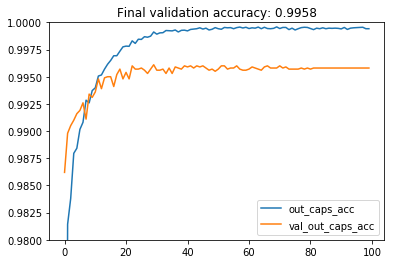

In [10]:
for label in ["out_caps_acc","val_out_caps_acc"]:
    plt.plot(hist.history[label],label=label)
plt.title("Final validation accuracy: {}".format(hist.history["val_out_caps_acc"][-1]))
plt.legend()
plt.ylim(0.98,1)
plt.show()

In [11]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = img[:, :, 0]
    return image

def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    
    print('-'*50)
    class_pred = np.argmax(y_pred, 1)
    class_test = np.argmax(y_test, 1)
    acc = np.sum(class_pred == class_test)/float(y_test.shape[0])*100
    print('Test accuracy: {:5.3f}%'.format(acc))
    print('Test error   : {:5.3f}%'.format((100-acc)))
    
    from PIL import Image

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255 
    print('-'*50)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

### Test set results
Testing error of [paper](https://arxiv.org/pdf/1710.09829.pdf) was 0.25% with standard deviation of 0.005 after 3 trials. 

My error was 0.420%, not quite as low; I did not reproduce the result entirely.
This is probablly because I only consider one testing set and not three, and some of the parameter values are not the same as [paper](https://arxiv.org/pdf/1710.09829.pdf), e.g., number of epochs or parameters of Adam's optimizer. (The paper use Tensorflow for implementation.)

Unfortunatelly, the error of my CapsNet was even higher than the error produced by the baseline (0.39%). 
However, when I try fitting this baseline model to the MNIST data in [my prebious blog](https://fairyonice.github.io/CNN%20modeling%20with%20image%20translations%20using%20MNIST%20data.html), the validation loss of my baseline model was 0.5%. 
At least, the validation loss of my CapsNet model is less than the validation loss of the my baseline.
This means that my CapsNet model classified additional 12 (= 10000x(0.540 - 0.420)/100) images correctly in comparisons to my baseline model.

Correct classification of additional 8 images sounds low, and the statistical significance of improvment from the CapsNet is questionable for MNIST-like data. 
[paper](https://arxiv.org/pdf/1710.09829.pdf) validates CapsNet's performance on other data such as CIFAR10 or smallNORB. I should also consider applying CapsNet for more complex image data.


--------------------------------------------------
Test accuracy: 99.580%
Test error   : 0.420%
--------------------------------------------------


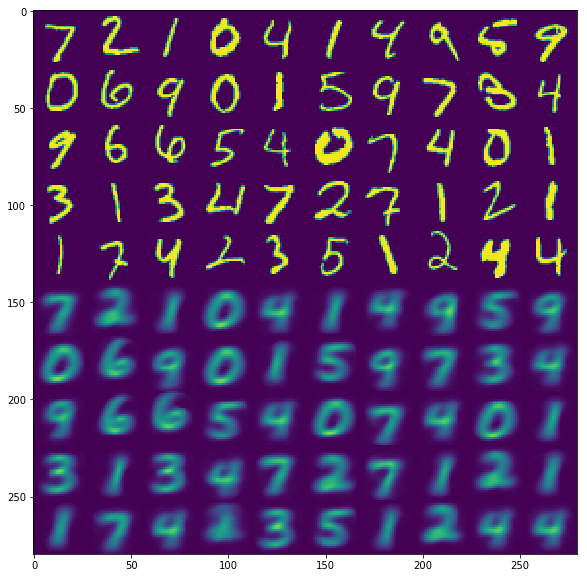

In [12]:
ntest = x_test.shape[0]
test(model=model, data=(x_test[:ntest], y_test[:ntest]))

# Interprete Capsule Networks

Since the Capsule Network passing the acitivity vector to encoding of only one digit and zeroing out other digits (Mask method is doing this in the code), the activity vector of the correct class $\boldsymbol{v}_{\textrm{correct}}$ should be able to reconstruct the image well while the activity vector of the incorrect $\boldsymbol{v}_{\textrm{not correct}}$ cannot reconstruct sensible image. 
Let's see if this is the case.

In order to visualize the reconstructed images from every activity vector, we create a decoder model that takes activity vectors as input and output the reconstructed images.

In [13]:
dim_vector = 16
activity_vec = layers.Input(shape=(dim_vector,),name="activity_vec")
decoder_out = Decoder(activity_vec)
decoder_model = models.Model(activity_vec,decoder_out)
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activity_vec (InputLayer)    (None, 16)                0         
_________________________________________________________________
FC1 (Dense)                  (None, 512)               8704      
_________________________________________________________________
FC2 (Dense)                  (None, 1024)              525312    
_________________________________________________________________
FC3 (Dense)                  (None, 784)               803600    
_________________________________________________________________
out_recon (Reshape)          (None, 28, 28, 1)         0         
Total params: 1,337,616
Trainable params: 1,337,616
Non-trainable params: 0
_________________________________________________________________


Transfer the weights trained Capsule Network to the newly created decoder model.

In [14]:
for layer_CapsNet in model.layers:
    for layer_decoder in decoder_model.layers:
        if layer_decoder.name == layer_CapsNet.name:
            weight = layer_CapsNet.get_weights()
            if len(weight) != 0:
                layer_decoder.set_weights(weight)


## Example reconstructed images from activity vector of each capsule in DigitCaps layer

### Observations

- Expectedly, the reconstructed image from the activity vector of the correct class reproduces the better image. We also see that when the model is not confident about the prediction ($|| \boldsymbol{v}_j ||$ is high for multiple $j$), all reconstructed images of clases with high predicted probabilities are also well represented. See the example image for digit 2. The model thinks that the digit could be either digit 2 or 7.
 
- I am slighly surprized to see that many lengths of output vector of the capsule are almost zero, i.e., the probability that the image belongs to wrong digit class is almost zero, correctly. As the margin loss function was defined as:
$$
L_k = T_k \max(0, m^+ - || \boldsymbol{v}_k ||)^2 +
(1-T_k) \max(0, || \boldsymbol{v}_k || - m^-)^2
$$
where $T_k=1$ iff a digit of class $k$ is present, and $m^+=0.9$ and $m^-=0.1$.
I interpret this loss as "avoid model being over confident. The model is good enough if the probability estimate is < 0.1 when the class is incorrect and > 0.9 if the probability estimate is > 0.9 when the class is correct." So the probability estimate of 0.1 is just as confident as 0 that the class is incorrect, and 0.9 is just as confident as 0.95 that the class is correct.
However, the model seems to return probability estimates of 0 pretty often when the class is incorrect.

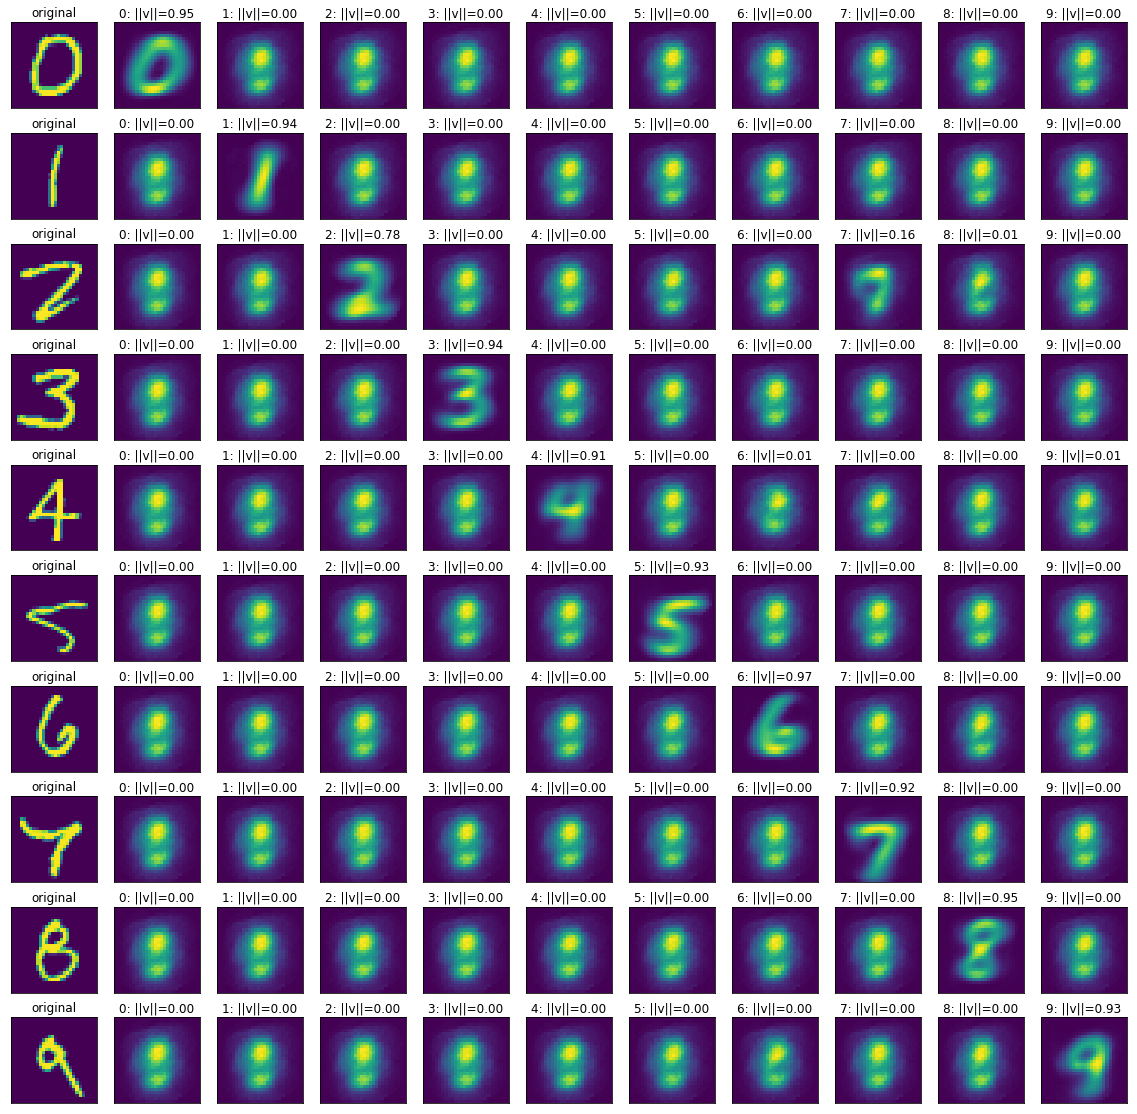

In [37]:
#Npic = 5
#random_pick_pics = np.random.choice(x_test.shape[1],Npic,replace=False)
random_pick_pics = [
                    10, ## 0
                    1097, ## 1
                    924, ## 2 looks like 7
                    912, ## 3
                    5923, ## 4
                    1948, ## 5
                    3923, ## 6
                    124,## 7
                    800,## 8
                    7  ## 9
                   ]

Npic = len(random_pick_pics)
count = 1
fig = plt.figure(figsize=(20,2*Npic))
for image_index in random_pick_pics:
    orig_image = x_test[[image_index]]
    V = model_wo_decoder.predict(orig_image)
    orig_image = orig_image.reshape(28,28)
    

    ax = fig.add_subplot(Npic,11,count,xticks=[],yticks=[])
    ax.imshow(orig_image)
    ax.set_title("original")
    count += 1
    
    for myclass, pred_class in enumerate(range(V.shape[1])):
        Vpred_class = V[0,pred_class,:]
        reconst_image = decoder_model.predict(Vpred_class.reshape(1,16))
    
        ax = fig.add_subplot(Npic,11,count,
                             xticks=[],yticks=[])
        ax.imshow(reconst_image.reshape(28,28))
        ax.set_title("{}: ||v||={:3.2f}".format(myclass,np.sum(Vpred_class**2)))
        count += 1
plt.show()

Evaluate the values of activity vectors 

In [16]:
activity_vecs = model_wo_decoder.predict(x_test)
print(activity_vecs.shape)

(10000, 10, 16)


## Dimension perturbations 

One thing that really fascinates me about the CapsNet was the interpretability of the model.
When working with deep learning models for customer projects, I often have difficulty in explaining why the model work (or not work) to non-exparts.
Many researchers put efforts to visualize and interpret the model and I also discuss this in the [previous post](https://fairyonice.github.io/Visualization%20of%20Filters%20with%20Keras.html). 
It would be great if CapsNet can help me interpret the model! 




[Hinton](https://arxiv.org/pdf/1710.09829.pdf) discusses the interpretability and says:

"
_... dimensions of a digit capsule should learn to span the space of variations in the way digits of that class are instantiated.
These variations include stroke thickness, skew and width.
They also include digit-specific variations such as the length of the tail of a 2. We can see what the individual dimensions represent by making use of the decoder network._
"


Each dimention of the acivity vector could represent stroke, thickness etc?! That is great! 




The intepretability of the model was explained with Figure 4 of page 6 in [paper](https://arxiv.org/pdf/1710.09829.pdf), which shows the reconstruction when one of the 16 dimensions in the DigitCaps representation is tweaked by intervals of 0.05 in the range [-0.25,0.25].
Figure 4 explains what the individual dimensions of a capsule represent. 
I try to reproduce images similar to Figure 4.




Although the range of the dimensions are set to [-0.25,0.25], I rather want to make the range to span the entire possible values of the activity vector.
Therefore, first, evaluate the range of each element of the activity vector of a capsule.

Remind you that the activity vector $\boldsymbol{v}_j$ is defined as:

$$
\boldsymbol{v}_j = 
\frac{
||\boldsymbol{s}_j||^2
}{
1 + ||\boldsymbol{s}_j||^2
}
\frac{
\boldsymbol{s}_j
}{
 ||\boldsymbol{s}_j||
}
$$

As it is defined to be scaled normalized vector with a scale ranging between 0 and 1, each element of the activity vector ranges between -1 and 1.

The following code shows that the range is rather narrower.

The range of each element of the output vector:
Min: -0.44
Max: 0.40


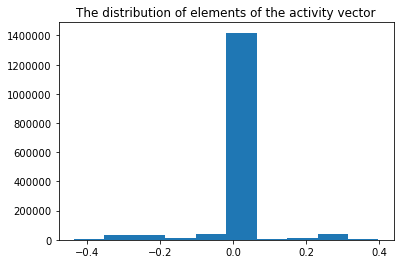

In [17]:
min_avec = activity_vecs.min()
max_avec = activity_vecs.max()
print("The range of each element of the output vector:")
print("Min: {:4.2f}".format(min_avec))
print("Max: {:4.2f}".format(max_avec))
avec_range = np.arange(min_avec,max_avec,(max_avec- min_avec)/5)
plt.hist(activity_vecs.flatten())
plt.title("The distribution of elements of the activity vector")
plt.show()


## Observations 
- [Paper](https://arxiv.org/pdf/1710.09829.pdf) says "We found that one dimension (out of 16) of the capsule almost always represents the width of the digit". 
In my particular experiment, dimension 1 (and maybe 3 and 12) seems to measure the width of the digit.
- The thickness of the stroke is represented by dimension 8.
- For digit 6, the size of the loop relative to the size of the tail is measured by dimension 10. This seems to be the case for digit 4, and digit 9.

In general, the intepretation is not super straightfoward, and you have to sit down and stare at the image a while. But it seems to be not impossible to interpret each dimension of the activity vector.

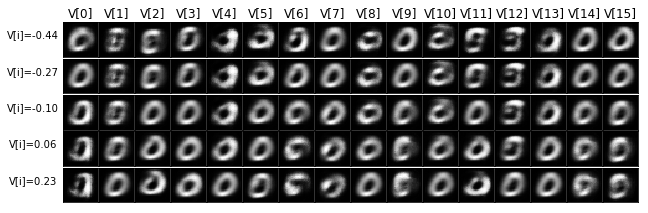

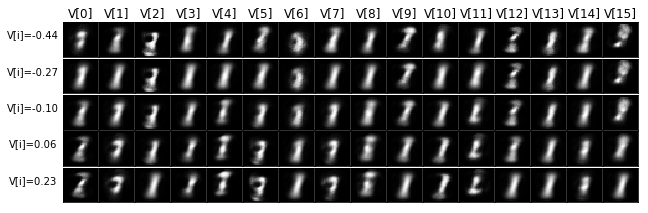

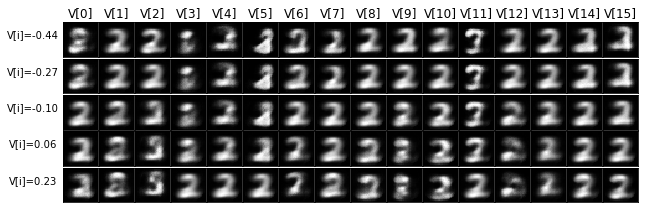

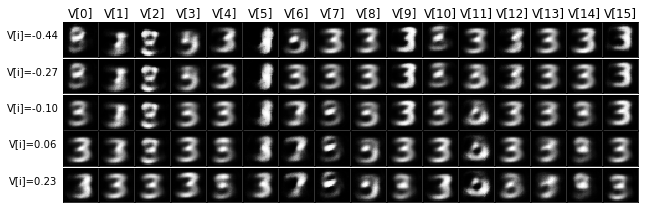

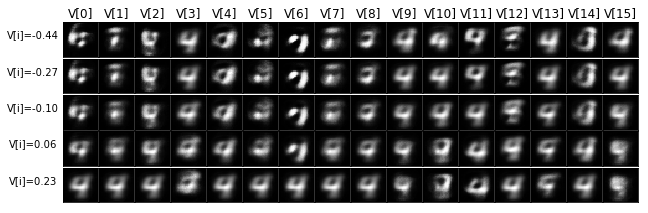

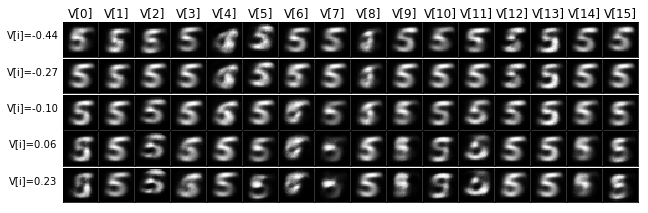

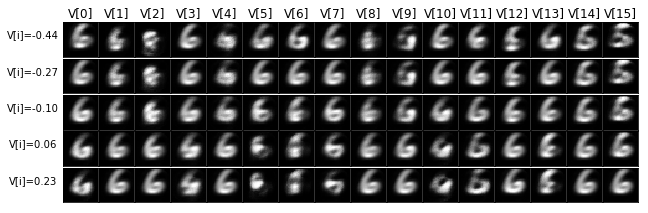

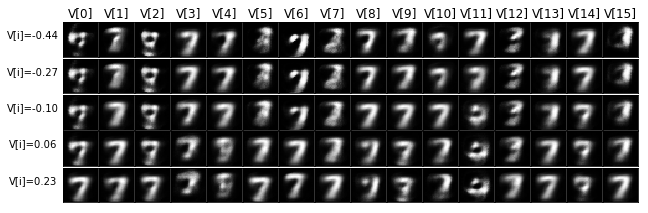

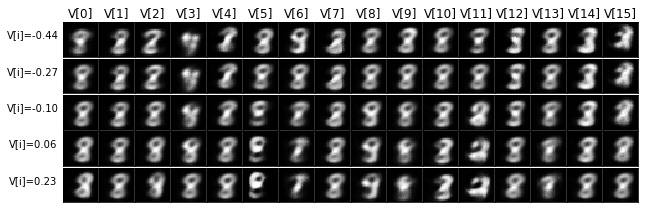

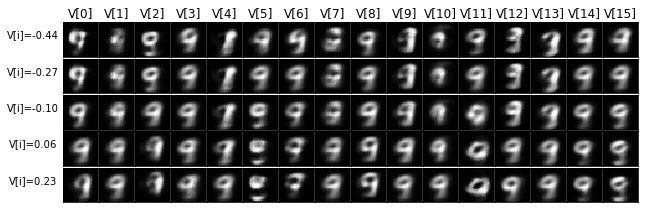

In [18]:
from copy import copy
def plot_dimension_perturbation(x_test1,y_test1,avec_range):  
    '''
    x_test1 : np.array() of 1 x 28 x 28, containing image
    y_test1 : np.array() of length 10, binary array indicating class 
    avec_range : the value of activity vectors to replace the original
    '''
    y_test1 = y_test1.flatten()
    true_class = np.where(y_test1==1)[0]
    
    V = model_wo_decoder.predict(x_test1)
    
    const = 0.5
    fig = plt.figure(figsize=(16*const, len(avec_range)*const))
    fig.subplots_adjust(hspace=0.05,wspace=0.0001,
                        left=0,right=1,bottom=0, top=1)
    count = 1
    for value in avec_range:
        for di in range(V.shape[2]):
        
            activity_vec = (copy(V[0,true_class,:])).flatten()
        
            activity_vec[di] = value
            reconst_image = decoder_model.predict(activity_vec.reshape(1,16))
            
            ax = fig.add_subplot(len(avec_range),16,count,
                                 xticks=[],yticks=[])
            ax.imshow(reconst_image.reshape(28,28),cmap="gray")
            if value == avec_range[0]:
                ax.set_title("V[{}]".format(di))
            if di == 0:
                ax.set_ylabel("V[i]={:3.2f}".format(value),
                             rotation=0, fontsize=10, labelpad=30)
            count += 1
    plt.show()  
for image_index in [296, ## 0
                    920, ## 1
                    421, ## 2
                    369, ## 3
                    399, ## 4
                    502, ## 5
                    123, ## 6
                    2123,## 7
                    998, ## 8
                    1013 ## 9
                    ]:

    plot_dimension_perturbation(x_test[[image_index]],
                                y_test[[image_index]],
                                avec_range)    
